<a href="https://colab.research.google.com/github/Tieck-IT/Study/blob/main/tf_keras/%EB%8F%84%EB%A1%9C%EC%9D%B4%EB%AF%B8%EC%A7%80segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [172]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install tensorflow-datasets

In [2]:
!pip install tfds-nightly

     |████████████████████████████████| 4.1 MB 8.0 MB/s 


In [173]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds


ds = tfds.load('lost_and_found', split='train', batch_size=400)

In [174]:
dataset = next(iter(ds))

In [175]:
print(dataset.keys())

dict_keys(['image_id', 'image_left', 'segmentation_label'])


In [176]:
images = dataset['image_left'].numpy()
labels = dataset['segmentation_label'].numpy()

In [177]:
print(images.shape)
print(labels.shape)

(400, 1024, 2048, 3)
(400, 1024, 2048, 1)


In [178]:
print(np.max(labels), np.min(labels))

38 0


In [179]:
labels[labels>1] = 1

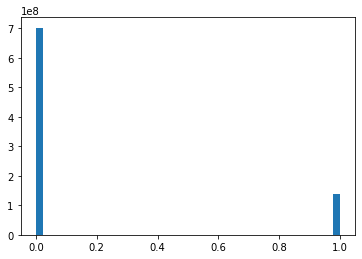

In [180]:
plt.hist(labels.flatten(), bins=45)
plt.show()

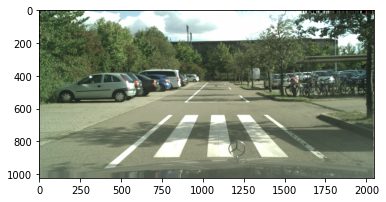

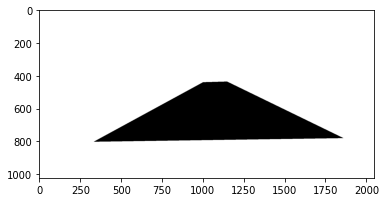

In [181]:
import matplotlib.pyplot as plt
plt.imshow(images[0])
plt.show()

plt.imshow(labels[0].squeeze(), cmap='binary')
plt.show()

In [182]:
print(labels[0][700,500:550,:].squeeze())

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [183]:
import cv2

resized_images = np.array([cv2.resize(image, (256,256),interpolation=cv2.INTER_AREA) for image in images])
resized_labels = np.array([cv2.resize(label, (256,256),interpolation=cv2.INTER_AREA) for label in labels])

In [184]:
# from skimage.transform import resize

# resized_images = np.array([resize(image, (256,256)) for image in images])
# resized_labels = np.array([resize(label, (256,256)) for label in labels])

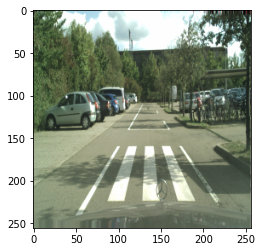

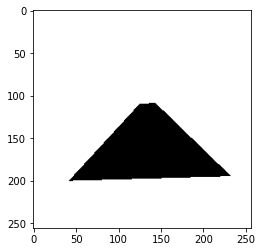

In [185]:
plt.imshow(resized_images[0])
plt.show()

plt.imshow(resized_labels[0].squeeze(), cmap='binary')
plt.show()

In [186]:
print(resized_images.shape)
print(resized_labels.shape)

(400, 256, 256, 3)
(400, 256, 256)


In [187]:
print(labels[0][700,500:550,:].squeeze())

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [188]:
x = resized_images.astype(np.float) / 255.
y = resized_labels.astype(np.int)

In [189]:
np.max(np.ceil(resized_labels))

1.0

In [190]:
np.max(y), np.max(resized_labels)

(1, 1)

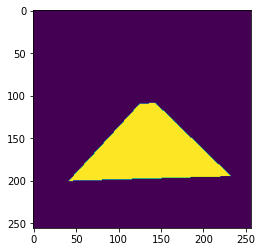

In [191]:
plt.imshow(y[0].squeeze())

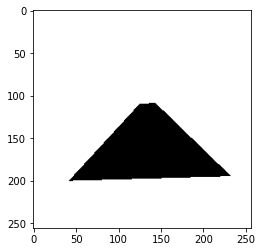

In [192]:
plt.imshow(resized_labels[0].squeeze(), cmap='binary')
plt.show()

In [193]:
x.shape, y.shape

((400, 256, 256, 3), (400, 256, 256))

In [194]:
CATEGORY_COUNT = np.max(labels)
print("CATEGORY_COUNT =", CATEGORY_COUNT)

CATEGORY_COUNT = 1


In [195]:
split_index = int(x.shape[0]*0.8)
train_x, test_x = x[:split_index], x[split_index:]
train_y, test_y = y[:split_index], y[split_index:]

In [196]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(320, 256, 256, 3)
(320, 256, 256)
(80, 256, 256, 3)
(80, 256, 256)


import matplotlib.pyplot as plt

def plotTrainData(x, y, set_type):
    print(set_type)  
    for i in range(3):
        ix = np.random.randint(0, len(x))
        plt.subplot(1,2,1)
        plt.imshow(x[ix])
        
        plt.subplot(1,2,2)
        plt.imshow(np.squeeze(y[ix]), 'binary') # np.squeeze()는 (256,26,1)을 (256,256)으로 변환
        plt.show()
        
plotTrainData(train_x, train_y, 'train')
plotTrainData(test_x, test_y, 'test')

In [197]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

def unet(category_count, input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up, conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up, conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up, conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up, conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(category_count, (1, 1),  padding='same')(conv9)
    # conv10 = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [198]:
CATEGORY_COUNT

1

In [199]:
# model = unet(CATEGORY_COUNT)
model = unet(1)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 256, 256, 32  128        ['conv2d_19[0][0]']              
 ormalization)                  )                                                           

In [200]:
train_x.shape

(320, 256, 256, 3)

In [201]:
# tf.keras.losses.BinaryCrossentropy(
#     from_logits=False, label_smoothing=0.0, axis=-1,
#     reduction=losses_utils.ReductionV2.AUTO, name='binary_crossentropy'
# )

# Real-time Loss Graph

In [202]:
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):

    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []

    self.fig = plt.figure()

    self.logs = []


  def on_epoch_end(self, epoch, logs={}):

    self.logs.append(logs)
    self.x.append(self.i)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.i += 1

    fig = plt.figure(figsize = (10,10))
    clear_output(wait=True)
    plt.plot(self.x, self.losses, label="loss")
    plt.plot(self.x, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])

plot_loss = PlotLosses()

# ModelCheckPoint

In [203]:
from tensorflow.keras.callbacks import ModelCheckpoint
SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/dataset/"
model_check_point = ModelCheckpoint(SAVE_DIR+'best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

In [204]:
callbacks = [plot_loss,model_check_point]

# 모델 훈련

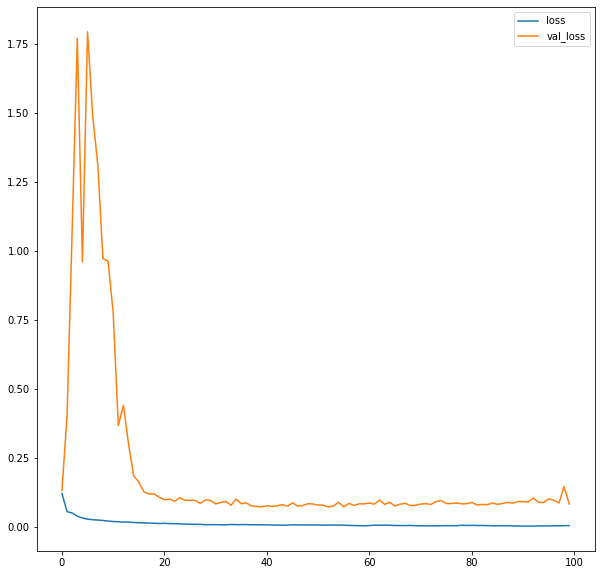

loss =  0.0057113636285066605 , val_loss =  0.08391518145799637
4/4 [==============================] - 3s 721ms/step - loss: 0.0057 - accuracy: 0.9977 - val_loss: 0.0839 - val_accuracy: 0.9855


In [221]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy

# 모델 컴파일
# loss=SparseCategoricalCrossentropy(from_logits=True)
loss = BinaryCrossentropy(from_logits=True)

model.compile(loss=loss, optimizer="Adam", metrics=['accuracy'])

# 학습
hist = model.fit(train_x, train_y, validation_split=0.2, epochs=100, batch_size=64, callbacks = callbacks)


# 모델 학습 및 정확도 보기

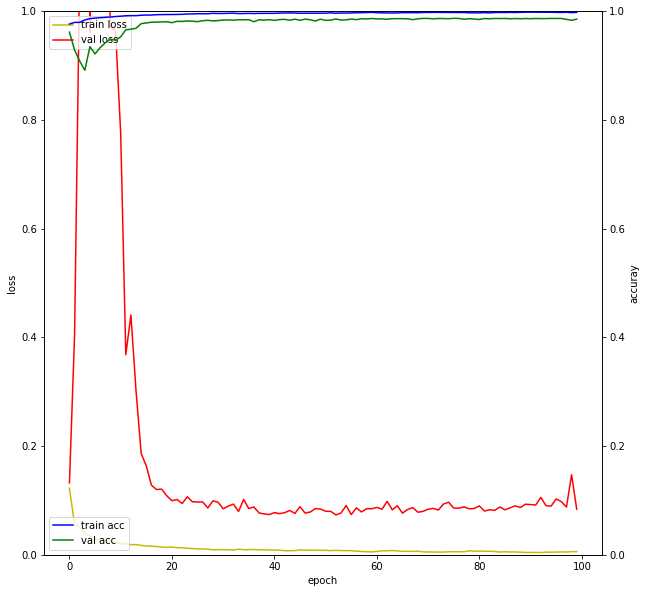

In [222]:
fig, loss_ax = plt.subplots(figsize=(10,10))
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 테스트 결과 보기

In [223]:
import matplotlib.pyplot as plt
def plotPredictions(model, train_x, train_y, test_x, test_y):

    ix = np.random.randint(0, len(train_x))

    
    
    input_ = train_x[ix:ix+1]
    mask_ = train_y[ix:ix+1]

    preds_train = model.predict(input_)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)


    # train
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    plt.imshow(mask_[0][:,:], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_train_t[0][:,:,0], 'gray')
    plt.show()

    ix = np.random.randint(0, len(test_x))
    input_ = test_x[ix:ix+1]
    mask_ = test_y[ix:ix+1]

    # test
    preds_test = model.predict(input_)
    preds_test_t = (preds_test > 5.0).astype(np.uint8)
    preds_test_t = preds_test
    
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    
    plt.imshow(mask_[0][:,:], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_test_t[0][:,:,0], 'gray')
    plt.show()

In [224]:

def multi_plotPredictions(model, train_x, train_y, test_x, test_y,img_num = 3):
    
    imcnt= 0

    while imcnt < img_num:

        print("="*80)
        print(imcnt+1,"번째 이미지")
        print("="*80)
        plotPredictions(model, train_x, train_y, test_x, test_y)
        imcnt +=1
    

1 번째 이미지
1/1 [==============================] - 0s 426ms/step - loss: 0.0136 - accuracy: 0.9953


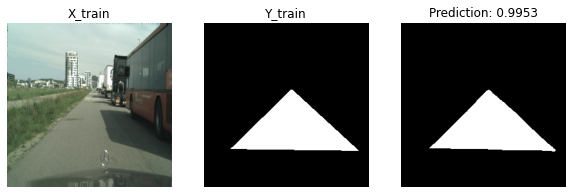

1/1 [==============================] - 0s 29ms/step - loss: 0.1260 - accuracy: 0.9772


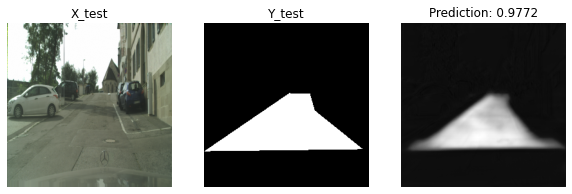

2 번째 이미지
1/1 [==============================] - 0s 26ms/step - loss: 0.0058 - accuracy: 0.9973


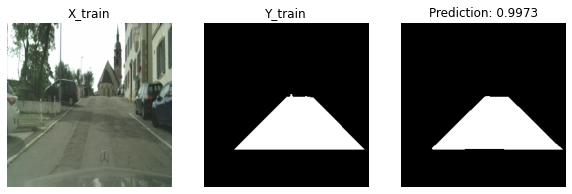

1/1 [==============================] - 0s 27ms/step - loss: 0.1260 - accuracy: 0.9772


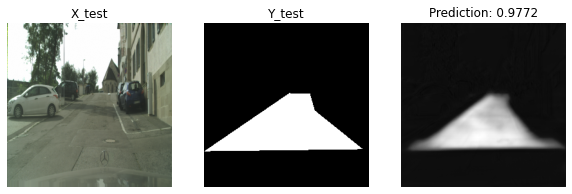

3 번째 이미지
1/1 [==============================] - 0s 27ms/step - loss: 0.0117 - accuracy: 0.9957


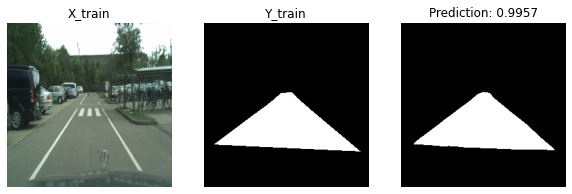

1/1 [==============================] - 0s 29ms/step - loss: 0.0233 - accuracy: 0.9921


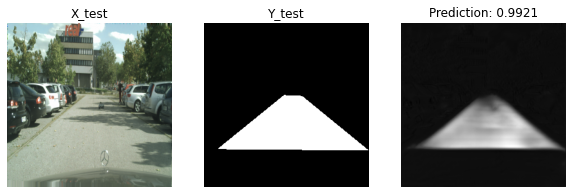

4 번째 이미지
1/1 [==============================] - 0s 25ms/step - loss: 0.0258 - accuracy: 0.9934


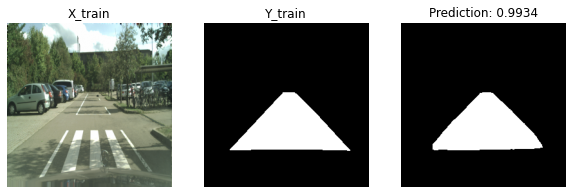

1/1 [==============================] - 0s 26ms/step - loss: 0.3640 - accuracy: 0.9495


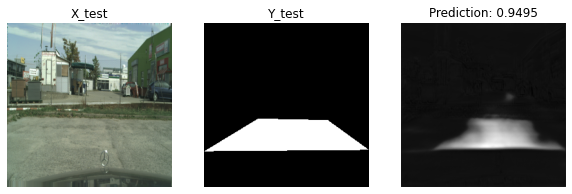

5 번째 이미지
1/1 [==============================] - 0s 23ms/step - loss: 0.0182 - accuracy: 0.9935


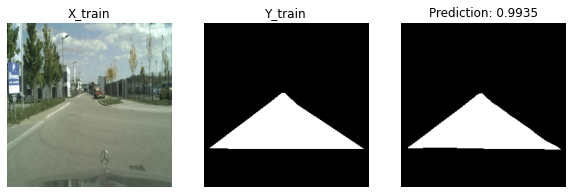

1/1 [==============================] - 0s 23ms/step - loss: 0.0687 - accuracy: 0.9874


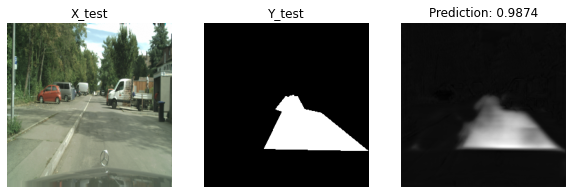

In [225]:
multi_plotPredictions(model, train_x, train_y, test_x, test_y,5)

## 원래 크기로 업사이즈 하기

In [229]:
images.shape, labels.shape

((400, 1024, 2048, 3), (400, 1024, 2048, 1))

In [234]:
type(label)

numpy.ndarray

In [233]:
upsized_train_images = np.array([cv2.resize(image, (2048,1024),interpolation=cv2.INTER_AREA) for image in train_x[:10]])
upsized_train_labels = np.array([cv2.resize(label.astype('float32'), (2048,1024),interpolation=cv2.INTER_AREA) for label in train_y[:10]])

upsized_test_images = np.array([cv2.resize(image, (2048,1024),interpolation=cv2.INTER_AREA) for image in test_x[:10]])
upsized_test_labels = np.array([cv2.resize(label.astype('float32'), (2048,1024),interpolation=cv2.INTER_AREA) for label in test_y[:10]])

In [235]:
upsized_train_images.shape

(10, 1024, 2048, 3)

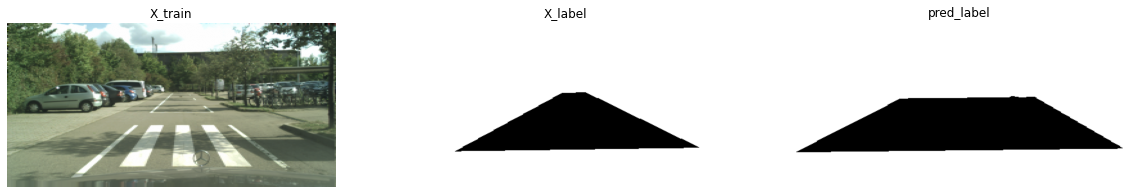

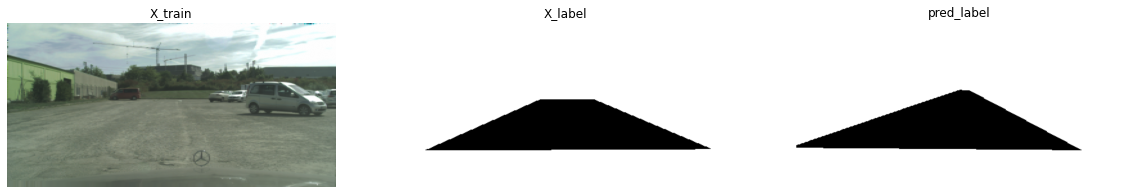

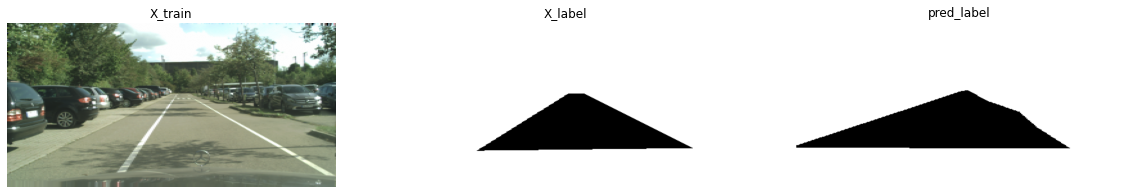

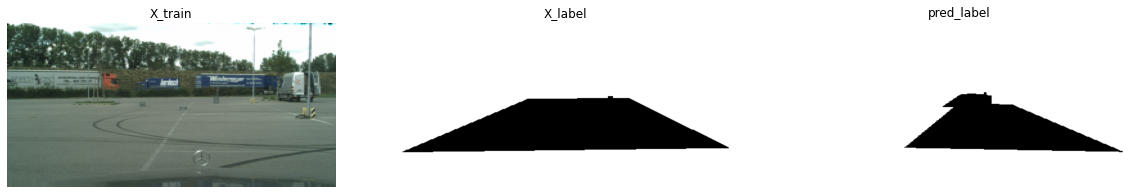

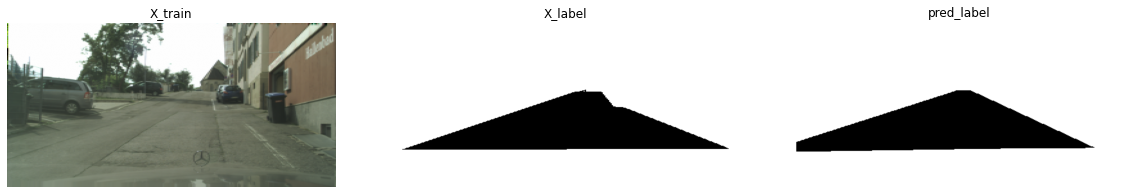

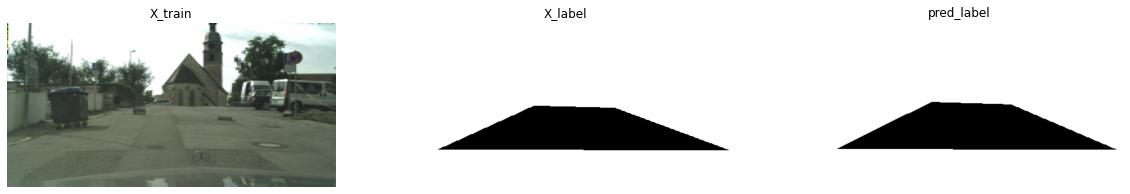

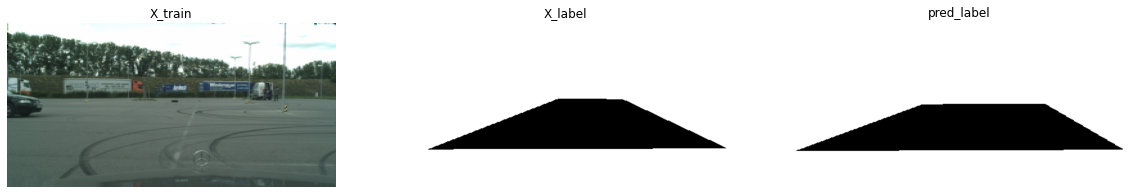

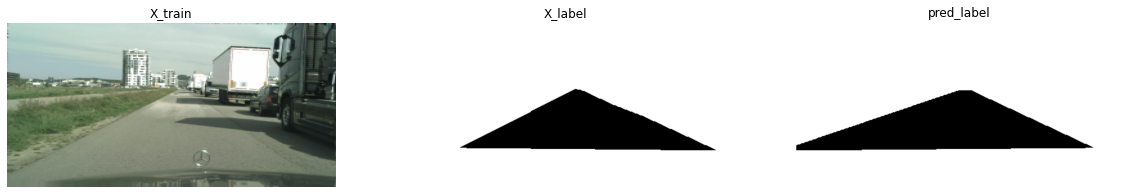

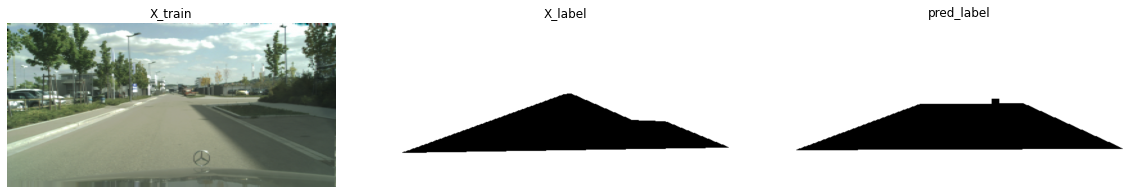

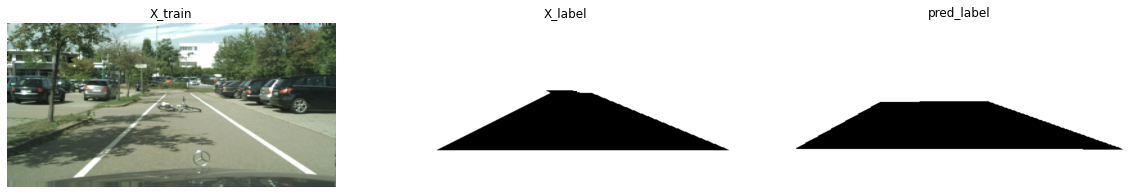

In [244]:
for tr_img, tr_label, test_label in zip(upsized_train_images,upsized_train_labels,upsized_test_labels):
    fig = plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(tr_img)
    # plt.show()

    plt.subplot(1,3,2)
    plt.title("X_label")
    plt.axis('off')
    plt.imshow(tr_label,cmap='binary')
    # plt.show()

    plt.subplot(1,3,3)
    plt.title("pred_label")
    plt.axis('off')
    plt.imshow(test_label,cmap='binary')
    plt.show()
    

## resize 된 이미지

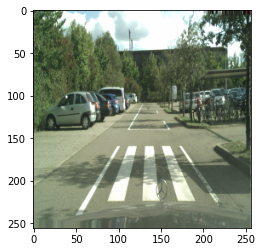

In [215]:
plt.imshow(train_x[0])

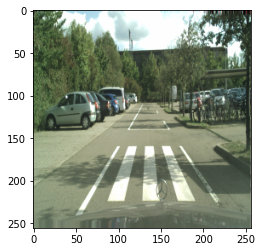

In [131]:
plt.imshow(resized_images[0])

In [132]:
train_x.shape

(160, 256, 256, 3)

1/1 [==============================] - 0s 23ms/step - loss: 0.0131 - accuracy: 0.9964


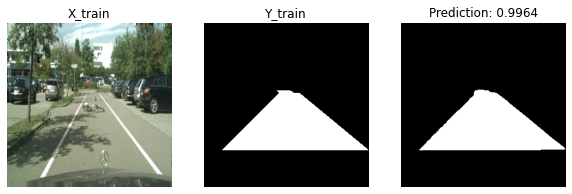

1/1 [==============================] - 0s 24ms/step - loss: 0.0286 - accuracy: 0.9941


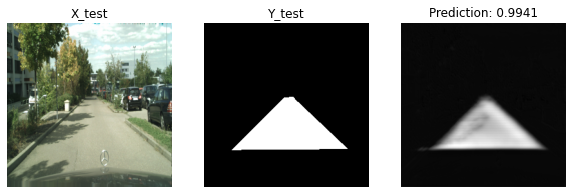

In [141]:
plotPredictions(model, train_x, train_y, test_x, test_y)

# 원본 이미지와 label 형태 체크하기

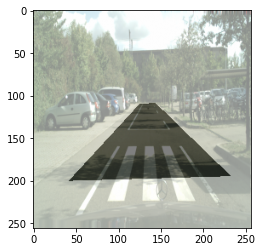

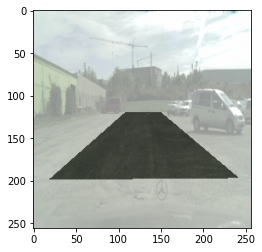

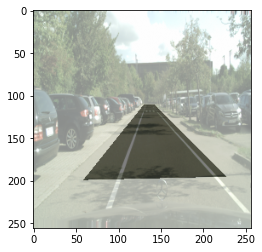

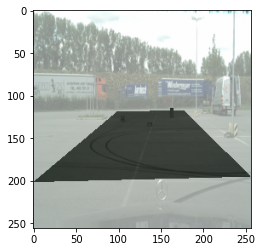

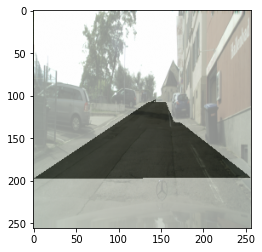

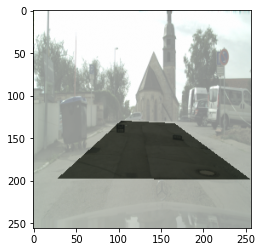

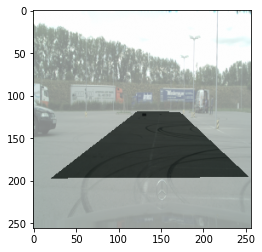

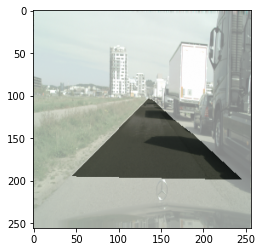

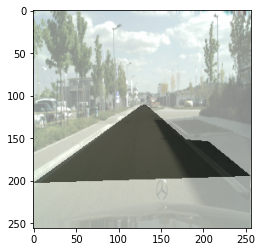

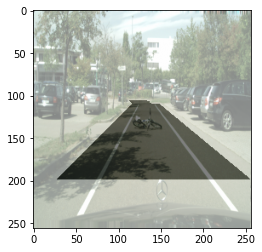

In [134]:
for image,label in zip(train_x[:10],train_y[:10]):
    plt.imshow(image)
    plt.imshow(label,cmap='binary',alpha=0.5)
    plt.show()